# Setup

In [ ]:
# Install Necessary Packages
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assumes you have a working directory structure like
```
working_dir ->
  input
      -> "TCGA_pyradiomics_t1.csv"
      -> "TCGA_GBM_LGG_clinical_data_for_task2_updated.csv"
  output
  notebook
```

In [ ]:
WORKING_DIR = "/content/drive/MyDrive/Imaging-Project"

# 1. Data Loading

## 1.1 Load TCGA data with clinical labels

In [ ]:
# Load radiomics features
os.makedirs(os.path.join(WORKING_DIR, "input"), exist_ok=True)
radiomics_path = os.path.join(WORKING_DIR, "input/TCGA_pyradiomics_t1.csv")
df_radiomics = pd.read_csv(radiomics_path)
print(f"✅ Loaded radiomics data: {df_radiomics.shape}")
print(f"Columns: {df_radiomics.columns.tolist()}")

# Load clinical data
clinical_path = os.path.join(WORKING_DIR,"input/TCGA_GBM_LGG_clinical_data_for_task2_updated.xlsx")
df_clinical = pd.read_excel(clinical_path)
print(f"✅ Loaded clinical data: {df_clinical.shape}")
print(f"Columns: {df_clinical.columns.tolist()}")


# Merge on Patient ID
tcga_df_merged = pd.merge(df_radiomics,
                     df_clinical,
                     left_on="ID",
                     right_on = "Row.names")


#df_radiomics.head()
#df_clinical.head()
print("\nMerged head:")
tcga_df_merged.head()

✅ Loaded radiomics data: (167, 131)
Columns: ['ID', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Configuration_Settings', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Maximum', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Spacing', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Versions_SimpleITK', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder

,ID,diagnostics_Configuration_EnabledImageTypes,diagnostics_Configuration_Settings,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Hash,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Size,diagnostics_Image-original_Spacing,...,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Source,Row.names,Disease_Type,Gender,Race
0,TCGA-02-0006,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,cf7eef9f6f12a01d6619c43bdd3c73682ea3cb1a,502.0,41.681753,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,12.901075,0.280044,787.786220,2.556710,384.0,TCGA-GBM,TCGA-02-0006,GBM,FEMALE,UNKOWN
1,TCGA-02-0009,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,2a6de38eb2a01829058381d08d359df1a627f4df,844.0,37.192602,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,21.857589,0.353025,3588.790560,0.846338,4349.0,TCGA-GBM,TCGA-02-0009,GBM,FEMALE,WHITE
2,TCGA-02-0011,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,abd84417a8ec942a889872dfed222e0e1c56b5df,518.0,36.052124,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,52.467970,0.348870,18353.330279,0.380954,48610.0,TCGA-GBM,TCGA-02-0011,GBM,FEMALE,WHITE
3,TCGA-02-0027,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,36b7a0b79122686dd0546bc3e79e2695d3118138,2474.0,177.964626,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,23.419801,0.398880,4519.303940,0.627954,7587.0,TCGA-GBM,TCGA-02-0027,GBM,FEMALE,WHITE
4,TCGA-02-0033,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,9b8efeae3748d9049ab7982cac58a6c07b6b0477,880.0,35.767669,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,27.698853,0.493544,3604.103902,0.510903,7137.0,TCGA-GBM,TCGA-02-0033,GBM,MALE,WHITE


## 1.2 Load Rembrandt Data with clinical labels

In [ ]:
# Load test radiomics features

sheet_id = "1nDHMAQFY22SM0jlgfCcAjhE4O5C6xFzPClTnbjIODj8"
sheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

# read as pd dataframe
df_radiomics = pd.read_csv(sheet_url)

# extracts the portion of the patient id before the first underscore to match format of patient_id in clinical truth dataset
df_radiomics['patient_id'] = df_radiomics['patient_id'].str.extract(r'^(.*?)_')

# summary of radiomics data
print(f"✅ Loaded radiomics data: {df_radiomics.shape}")
print(f"Columns: {df_radiomics.columns.tolist()}")


# Load test clinical data
clinical_path = os.path.join(WORKING_DIR, "input/Rembrandt_Clinical_ground_truth_64set.txt")
df_clinical = pd.read_csv(clinical_path, sep="\t")  # tab-separated

print(f"✅ Loaded clinical data: {df_clinical.shape}")
print(f"Columns: {df_clinical.columns.tolist()}")

df_clinical['64.patient.set'] = df_clinical['64.patient.set'].str.replace('_', '-', regex=False)


# Merge on Patient ID
rembrandt_df_merged = pd.merge(df_radiomics,
                     df_clinical,
                     left_on="patient_id",
                     right_on = "64.patient.set")

# Clean Merged Data Set
print(f"✅ Merged data shape before dropping NA's in 'DISEASE_TYPE': {rembrandt_df_merged.shape}")
rembrandt_df_merged.dropna(subset=['DISEASE_TYPE'], inplace=True)
print(f"✅ Merged data shape after dropping NA's in 'DISEASE_TYPE': {rembrandt_df_merged.shape}")

# Print merged
print("\nMerged head:")
rembrandt_df_merged.head()

✅ Loaded radiomics data: (64, 130)
Columns: ['patient_id', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxis

,patient_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,64.patient.set,AGE_RANGE,GENDER,DISEASE_TYPE
0,900-00-5346,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},3169b58ab7bb0446f86ac3bb69a5b88bbc53d907,3D,...,1.489151e+06,471.492616,0.000385,0.731372,0.015565,0.001264,900-00-5346,NaN,,GBM
1,900-00-5342,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7a9511d8f500ffd117cbb7db7a80c183b6c8d123,3D,...,2.373929e+04,6.537673,0.000598,126.377421,0.021397,0.103040,900-00-5342,NaN,,GBM
2,900-00-5317,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},467c72afaa64e37b8ff02c4664bd11863c92ec31,3D,...,7.180045e+06,541.738705,0.000296,0.671269,0.009807,0.000784,900-00-5317,NaN,,GBM
3,900-00-5308,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6ea6b4ba1b08375259ac1723245da50c74d8e176,3D,...,2.747124e+06,102.550627,0.000707,1.124739,0.006130,0.004222,900-00-5308,NaN,,ASTROCYTOMA
5,900-00-5341,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d1a58d9e6d1cdfd7f1fa5a21b4ba0fcd684c8d3b,3D,...,3.671605e+06,129.721553,0.000596,1.335142,0.008283,0.003493,900-00-5341,NaN,,OLIGODENDROGLIOMA


## 1.3 Fuse TCGA and Rembrandt Dataset

In [ ]:
# Load the two datasets
df_tcga = tcga_df_merged.copy()
df_rembrandt = rembrandt_df_merged.copy()

### 1. Sanity Check: Compare columns
# Optional: show extra or missing columns
rembrandt_only = set(df_rembrandt.columns) - set(df_tcga.columns)
tcga_only = set(df_tcga.columns) - set(df_rembrandt.columns)
print("🔍 Columns only in Rembrandt:", rembrandt_only)
print("🔍 Columns only in TCGA:", tcga_only)

print("⚙️ Cleaning tcga and rembrandt datasets so columns match")
### Step 1: Drop non-feature columns
# Define columns to drop (based on your observation)
rembrandt_drop = ['patient_id', 'GENDER', 'AGE_RANGE', '64.patient.set']
tcga_drop = ['Row.names', 'Race', 'ID', 'Source', 'Gender']

df_rembrandt_clean = df_rembrandt.drop(columns=rembrandt_drop, errors='ignore')
df_tcga_clean = df_tcga.drop(columns=tcga_drop, errors='ignore')

### Step 2: Standardize the disease type column name
# Rename 'Disease_Type' in TCGA to match 'DISEASE_TYPE' in Rembrandt
df_tcga_clean.rename(columns={'Disease_Type': 'DISEASE_TYPE'}, inplace=True)

# Uppercase all values in the 'DISEASE_TYPE' column
df_tcga_clean['DISEASE_TYPE'] = df_tcga_clean['DISEASE_TYPE'].str.upper()

### Step 3: Sanity check — columns must now match
assert set(df_rembrandt_clean.columns) == set(df_tcga_clean.columns), \
       f"Column mismatch: {set(df_rembrandt_clean.columns) ^ set(df_tcga_clean.columns)}"

print("✅ df_tcga_clean columns match with df_rembrandt_clean")


### Step 4: Merge (Union)
df_combined = pd.concat([df_rembrandt_clean, df_tcga_clean], ignore_index=True)

print("✅ Combined dataset shape:", df_combined.shape)

df_combined.head()

🔍 Columns only in Rembrandt: {'GENDER', 'patient_id', 'AGE_RANGE', 'DISEASE_TYPE', '64.patient.set'}
🔍 Columns only in TCGA: {'Disease_Type', 'Row.names', 'Gender', 'Race', 'Source', 'ID'}
⚙️ Cleaning tcga and rembrandt datasets so columns match
✅ df_tcga_clean columns match with df_rembrandt_clean
✅ Combined dataset shape: (225, 130)


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,DISEASE_TYPE
0,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},3169b58ab7bb0446f86ac3bb69a5b88bbc53d907,3D,"(1.0, 1.0, 1.0)",...,0.131339,4.591756,0.004931,1.489151e+06,471.492616,0.000385,0.731372,0.015565,0.001264,GBM
1,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7a9511d8f500ffd117cbb7db7a80c183b6c8d123,3D,"(1.0, 1.0, 1.0)",...,0.005687,6.271977,0.049059,2.373929e+04,6.537673,0.000598,126.377421,0.021397,0.103040,GBM
2,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},467c72afaa64e37b8ff02c4664bd11863c92ec31,3D,"(1.0, 1.0, 1.0)",...,0.206479,4.676496,0.003412,7.180045e+06,541.738705,0.000296,0.671269,0.009807,0.000784,GBM
3,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6ea6b4ba1b08375259ac1723245da50c74d8e176,3D,"(1.0, 1.0, 1.0)",...,0.110053,4.046443,0.003488,2.747124e+06,102.550627,0.000707,1.124739,0.006130,0.004222,ASTROCYTOMA
4,v3.0.1,2.0.2,2.4.1,1.8.0,3.11.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d1a58d9e6d1cdfd7f1fa5a21b4ba0fcd684c8d3b,3D,"(1.0, 1.0, 1.0)",...,0.102376,3.803278,0.002459,3.671605e+06,129.721553,0.000596,1.335142,0.008283,0.003493,OLIGODENDROGLIOMA


# 2. Data Preprocessing, Scaling, Train/Test Split

In [ ]:

# ✅ Filter to 3 known cancer subtypes for modeling
target_classes = ["GBM", "OLIGODENDROGLIOMA", "ASTROCYTOMA"]
filtered_df = df_combined.copy()
filtered_df = filtered_df[filtered_df["DISEASE_TYPE"].isin(target_classes)].copy()

# 🎯 Set y as the multiclass disease type
y = filtered_df["DISEASE_TYPE"]

# 💠 Prepare initial feature matrix
X = filtered_df.drop(columns=["DISEASE_TYPE"])  # Keep only radiomic features

# 🔎 Sanity Check: initial shapes
print("✅ Initial shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("Class distribution:")
print(y.value_counts())

# 🧹 1. Check for missing values
missing = X.isnull().sum().sort_values(ascending=False)
print("\n🔍 Top 10 features with missing values:")
print(missing.head(10))

# 🛠 2. Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Align y
print(f"✅ After dropping missing values: X = {X.shape}, y = {y.shape}")

# 📋 3. Drop non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=["number"]).columns.tolist()
if non_numeric_cols:
    print(f"❗ Dropping non-numeric columns: {non_numeric_cols}")
    X = X.drop(columns=non_numeric_cols)
else:
    print("✅ No non-numeric columns found")

# 🧹 4. Drop metadata columns starting with 'diagnostics_'
diagnostic_cols = [col for col in X.columns if col.startswith("diagnostics_")]
if diagnostic_cols:
    print(f"❗ Dropping diagnostic metadata columns: {diagnostic_cols}")
    X = X.drop(columns=diagnostic_cols)
else:
    print("✅ No diagnostic metadata columns found")

# 📏 5. Standardize features
feature_names = X.columns # save feature column names for later
print(f"✅ Saved Feature names")

# 📏 6. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 🧪 Final confirmation
print(f"\n✅ Feature matrix standardized: X_scaled shape = {X_scaled.shape}")
print(f"✅ y (multiclass labels) shape = {y.shape}")
print("✅ Class label distribution:\n", y.value_counts())


✅ Initial shapes:
X: (207, 129)
y: (207,)
Class distribution:
DISEASE_TYPE
GBM                  120
ASTROCYTOMA           49
OLIGODENDROGLIOMA     38
Name: count, dtype: int64

🔍 Top 10 features with missing values:
diagnostics_Versions_PyRadiomics               0
diagnostics_Versions_Numpy                     0
diagnostics_Versions_SimpleITK                 0
diagnostics_Versions_PyWavelet                 0
diagnostics_Versions_Python                    0
diagnostics_Configuration_Settings             0
diagnostics_Configuration_EnabledImageTypes    0
diagnostics_Image-original_Hash                0
diagnostics_Image-original_Dimensionality      0
diagnostics_Image-original_Spacing             0
dtype: int64
✅ After dropping missing values: X = (207, 129), y = (207,)
❗ Dropping non-numeric columns: ['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configurat

## Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split once on multiclass labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print(f"\n✅ Train/Test split complete:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print("Train distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())



✅ Train/Test split complete:
X_train: (165, 107), y_train: (165,)
X_test: (42, 107), y_test: (42,)
Train distribution:
 DISEASE_TYPE
GBM                  96
ASTROCYTOMA          39
OLIGODENDROGLIOMA    30
Name: count, dtype: int64
Test distribution:
 DISEASE_TYPE
GBM                  24
ASTROCYTOMA          10
OLIGODENDROGLIOMA     8
Name: count, dtype: int64


# Creating Base Classifiers (Can Skip This Step and Go Straight to One Vs. Rest)


## 3. Base Classifier 1: GBM

### 3.1 Subsetting y_train to be for binary class logic

In [ ]:
# Define binary label for GBM
y_gbm_train = (y_train == "GBM").astype(int)

# 🔎 Sanity Check
print("✅ Feature matrix shape (X):", X_train.shape)
print("✅ Target vector shape (y):", y_gbm_train.shape)
print("\nClass Distribution (after binarization):")
print(y_gbm_train.value_counts())




✅ Feature matrix shape (X): (165, 107)
✅ Target vector shape (y): (165,)

Class Distribution (after binarization):
DISEASE_TYPE
1    96
0    69
Name: count, dtype: int64


### 3.2 Base Binary Classifier 1 (GBM)         [Best Model: XGBoost]


#### Model Training, Hyperparameter Tuning, and Evaluation

In [ ]:
# Define XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)

# Define scoring dictionary for use in CV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Baseline Cross-validation
xgb_cv_results = cross_validate(
    xgb_model,
    X_train,
    y_gbm_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring
)

# Display CV results
print("\n🎯 Cross-Validation Results (XGBoost):")
for metric in scoring.keys():
    print(f"{metric.capitalize()} (mean ± std): {xgb_cv_results['test_' + metric].mean():.3f} ± {xgb_cv_results['test_' + metric].std():.3f}")


from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_gbm_train)


# Save the best estimator (already trained and tuned)
xgb_best_model = grid_xgb.best_estimator_


os.makedirs(os.path.join(WORKING_DIR,"output"), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR,"output/full_training_models"), exist_ok=True)
with open(os.path.join(WORKING_DIR,"output/full_training_models/xgb_model_gbm.pkl"), "wb") as f:
    pickle.dump(xgb_best_model, f)

print("✅ XGBoost model saved as 'xgb_model_gbm.pkl'")


# Best model and parameters
xgb_best_model = grid_xgb.best_estimator_
print("Best XGBoost F1 score (CV):", grid_xgb.best_score_)
print("Best XGBoost params:", grid_xgb.best_params_)




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🎯 Cross-Validation Results (XGBoost):
Accuracy (mean ± std): 0.764 ± 0.048
Precision (mean ± std): 0.782 ± 0.037
Recall (mean ± std): 0.824 ± 0.060
F1 (mean ± std): 0.802 ± 0.042


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost model saved as 'xgb_model_gbm.pkl'
Best XGBoost F1 score (CV): 0.8475652545999145
Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


#### GBM XGBoost Feature Importance


Top 10 Features by Importance:
                               Feature  Importance
             original_ngtdm_Coarseness    0.092515
        original_shape_MinorAxisLength    0.063975
             original_shape_Sphericity    0.039684
     original_shape_SurfaceVolumeRatio    0.039206
original_shape_Maximum2DDiameterColumn    0.035672
original_glrlm_LowGrayLevelRunEmphasis    0.033315
            original_glcm_ClusterShade    0.025214
 original_gldm_SmallDependenceEmphasis    0.022816
            original_glszm_ZoneEntropy    0.022672
      original_glcm_MaximumProbability    0.022173


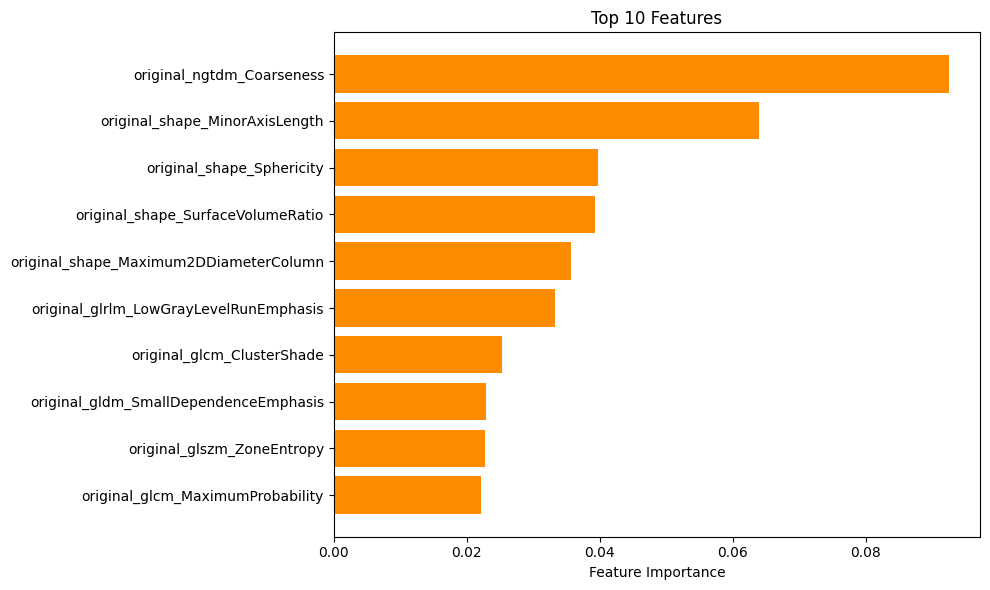

In [ ]:
def show_top_features(model, feature_names, top_n=10):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    print(f"\nTop {top_n} Features by Importance:")
    print(importance_df.to_string(index=False))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1], color='darkorange')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features')
    plt.tight_layout()
    plt.show()

    return importance_df


# Show top features from best XGBoost model
top_features_xgb = show_top_features(xgb_best_model, feature_names, top_n=10)


## 4. Base Classifier 2: Oligodendroglioma

### 4.1 Data Cleaning & Preprocessing

In [ ]:
# Define binary label for GBM
y_oligo_train = (y_train == "OLIGODENDROGLIOMA").astype(int)

# 🔎 Sanity Check
print("✅ Feature matrix shape (X):", X_train.shape)
print("✅ Target vector shape (y):", y_oligo_train.shape)
print("\nClass Distribution (after binarization):")
print(y_oligo_train.value_counts())


✅ Feature matrix shape (X): (165, 107)
✅ Target vector shape (y): (165,)

Class Distribution (after binarization):
DISEASE_TYPE
0    135
1     30
Name: count, dtype: int64


### 4.2 Base Binary Classifier 2 (Oligodendroglioma) [Best Model: Linear SVM]

#### Model Training, Hyperparameter Tuning, and Evaluation

In [ ]:


# ✅ STEP 1: BASELINE CV (SVM with probability=True)
baseline_model = SVC(kernel='linear', probability=True, random_state=42)
baseline_cv_results = cross_validate(baseline_model, X_train, y_oligo_train, cv=5, scoring='f1')
print("Baseline F1:", baseline_cv_results['test_score'].mean())

# ✅ STEP 2: GRID SEARCH TUNING
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)
grid_search.fit(X_train, y_oligo_train)

# ✅ STEP 3: Extract best model
best_svm_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)
print("Tuned Model Best F1 (CV average):", grid_search.best_score_)

# ✅ STEP 4: Save trained model
model_path = os.path.join(WORKING_DIR, "output/full_training_models/svm_model_oligodendroglioma1.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_svm_model, f)

print(f"✅ SVM model saved to: {model_path}")


Baseline F1: 0.23580808080808083
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Tuned Model Best F1 (CV average): 0.29758672699849176
✅ SVM model saved to: /content/drive/MyDrive/Imaging-Project/output/full_training_models/svm_model_oligodendroglioma1.pkl


#### Oligodendroglioma SVM Feature Importance


🔍 Top 10 Important Features (Linear SVM):
                                       Feature  Coefficient  Importance (abs)
         original_glrlm_RunLengthNonUniformity     2.884927          2.884927
                 original_glszm_ZonePercentage    -2.816828          2.816828
original_glszm_SizeZoneNonUniformityNormalized     2.775555          2.775555
                             original_glcm_MCC    -2.609649          2.609649
       original_glszm_LowGrayLevelZoneEmphasis     2.545524          2.545524
                            original_glcm_Imc2     2.388666          2.388666
                original_shape_MajorAxisLength    -2.343387          2.343387
                       original_ngtdm_Contrast    -1.947446          1.947446
                       original_ngtdm_Busyness    -1.693136          1.693136
          original_glszm_SizeZoneNonUniformity     1.687590          1.687590


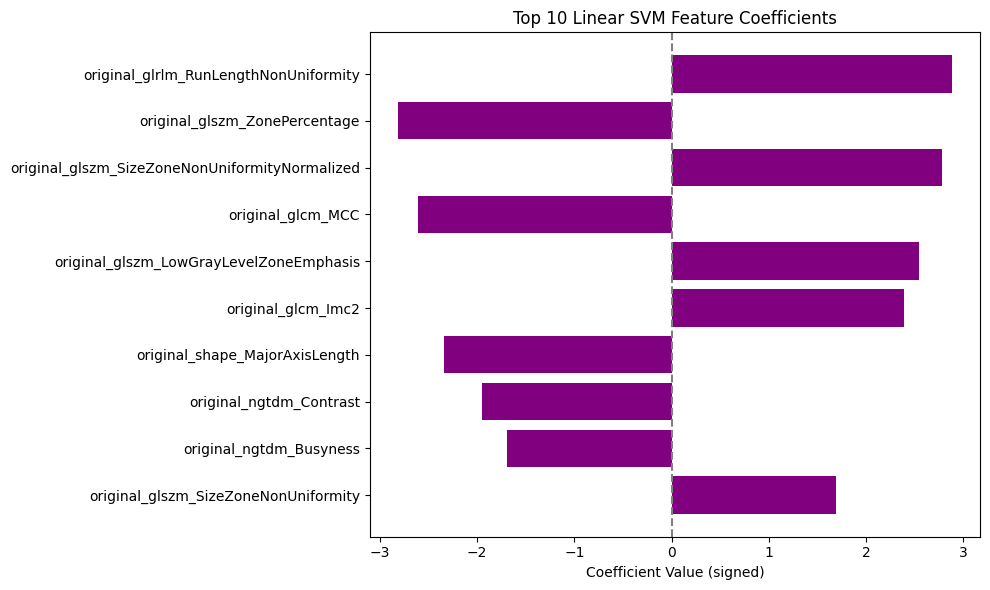

In [ ]:
# Check and extract if linear SVM
if best_svm_model.kernel == 'linear':
    # Get feature coefficients
    coef = best_svm_model.coef_.flatten()
    abs_coef = np.abs(coef)

    # Create DataFrame
    svm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
        'Importance (abs)': abs_coef
    }).sort_values(by='Importance (abs)', ascending=False)

    # Show Top 10
    print("\n🔍 Top 10 Important Features (Linear SVM):")
    print(svm_importance_df.head(10).to_string(index=False))

    # Optional Plot
    plt.figure(figsize=(10, 6))
    top_features = svm_importance_df.head(10)
    plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color='purple')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title("Top 10 Linear SVM Feature Coefficients")
    plt.xlabel("Coefficient Value (signed)")
    plt.tight_layout()
    plt.show()
else:
    print("❌ Feature importance not available: best SVM model is not linear.")


## 5. Base Classifier 3: Astrocytoma

### 5.2 Base Binary Classifier 3 (Astrocytoma) [Best Model: XGBoost]

In [ ]:
# Define binary label for GBM
y_astro_train = (y_train == "ASTROCYTOMA").astype(int)

# 🔎 Sanity Check
print("✅ Feature matrix shape (X):", X_train.shape)
print("✅ Target vector shape (y):", y_astro_train.shape)
print("\nClass Distribution (after binarization):")
print(y_astro_train.value_counts())


✅ Feature matrix shape (X): (165, 107)
✅ Target vector shape (y): (165,)

Class Distribution (after binarization):
DISEASE_TYPE
0    126
1     39
Name: count, dtype: int64


#### Create Resuable Model Training Function

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

def train_and_evaluate(model, X, y, scoring, cv_folds=5):
    """
    Trains and evaluates a model using Stratified K-Fold Cross-Validation.

    Parameters:
        model (sklearn estimator): The ML model (already initialized with desired parameters).
        X (numpy array or dataframe): Feature matrix.
        y (numpy array or series): Target vector.
        scoring (dict): Dictionary of scoring metrics.
        cv_folds (int): Number of CV folds (default 5).

    Returns:
        cv_results (dict): Cross-validation results.
        trained_model: Model fitted on the full dataset.
    """
    # 📋 Sanity Checks
    assert X.shape[0] == y.shape[0], "Mismatch: X and y must have same number of samples."
    assert hasattr(model, "fit"), "Model must have a fit() method."

    # 📋 Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # 🏃‍♂️ Run cross-validation
    print(f"\n🚀 Training {model.__class__.__name__} with {cv_folds}-Fold Cross-Validation...")
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    # 📈 Report CV performance
    print(f"\n🎯 Cross-Validation Results ({model.__class__.__name__}):")
    for metric in scoring.keys():
        mean_score = cv_results['test_' + metric].mean()
        std_score = cv_results['test_' + metric].std()
        print(f"{metric.capitalize()} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

    # 🏋️‍♂️ Train model on full dataset
    trained_model = model.fit(X, y)

    print(f"✅ Finished training {model.__class__.__name__} on full dataset.")

    return cv_results, trained_model


#### Call Function on Models  


In [ ]:
# 📋 Define evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# 📦 Define basic models
svm_model = SVC(kernel='linear', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
log_model = LogisticRegression(max_iter=1000, random_state=42)

# 📦 Define Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 📦 Define KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# 🏃‍♂️ Train and Evaluate each model

# SVM
svm_cv_results, svm_trained_model = train_and_evaluate(svm_model, X_train, y_astro_train, scoring)

# Random Forest
rf_cv_results, rf_trained_model = train_and_evaluate(rf_model, X_train, y_astro_train, scoring)

# Logistic Regression
log_cv_results, log_trained_model = train_and_evaluate(log_model, X_train, y_astro_train, scoring)

# Gradient Boosting
gb_cv_results, gb_trained_model = train_and_evaluate(gb_model, X_train, y_astro_train, scoring)

# KNN
knn_cv_results, knn_trained_model = train_and_evaluate(knn_model, X_train, y_astro_train, scoring)



🚀 Training SVC with 5-Fold Cross-Validation...

🎯 Cross-Validation Results (SVC):
Accuracy (mean ± std): 0.709 ± 0.062
Precision (mean ± std): 0.229 ± 0.230
Recall (mean ± std): 0.254 ± 0.261
F1 (mean ± std): 0.240 ± 0.245
✅ Finished training SVC on full dataset.

🚀 Training RandomForestClassifier with 5-Fold Cross-Validation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🎯 Cross-Validation Results (RandomForestClassifier):
Accuracy (mean ± std): 0.739 ± 0.031
Precision (mean ± std): 0.213 ± 0.275
Recall (mean ± std): 0.100 ± 0.122
F1 (mean ± std): 0.134 ± 0.165
✅ Finished training RandomForestClassifier on full dataset.

🚀 Training LogisticRegression with 5-Fold Cross-Validation...

🎯 Cross-Validation Results (LogisticRegression):
Accuracy (mean ± std): 0.715 ± 0.031
Precision (mean ± std): 0.219 ± 0.182
Recall (mean ± std): 0.182 ± 0.154
F1 (mean ± std): 0.199 ± 0.167
✅ Finished training LogisticRegression on full dataset.

🚀 Training GradientBoostingClassifier with 5-Fold Cross-Validation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🎯 Cross-Validation Results (GradientBoostingClassifier):
Accuracy (mean ± std): 0.727 ± 0.038
Precision (mean ± std): 0.331 ± 0.201
Recall (mean ± std): 0.200 ± 0.170
F1 (mean ± std): 0.237 ± 0.175
✅ Finished training GradientBoostingClassifier on full dataset.

🚀 Training KNeighborsClassifier with 5-Fold Cross-Validation...

🎯 Cross-Validation Results (KNeighborsClassifier):
Accuracy (mean ± std): 0.739 ± 0.056
Precision (mean ± std): 0.303 ± 0.285
Recall (mean ± std): 0.200 ± 0.203
F1 (mean ± std): 0.240 ± 0.236
✅ Finished training KNeighborsClassifier on full dataset.


I will move forward with Gradient Boosting

#### Try different feature combinations for Gradient Boosting

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

# 📋 Define your model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 📋 RFECV setup
rfecv = RFECV(
    estimator=gb_model,
    step=1,                     # Remove 1 feature at a time
    cv=StratifiedKFold(5),       # 5-fold Stratified CV
    scoring='f1',                # Optimize for F1 score
    n_jobs=-1                    # Use all CPU cores
)

# 🏃‍♂️ Fit RFECV
rfecv.fit(X_train, y_astro_train)

# 📊 Results
print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = np.array(feature_names)[rfecv.support_]
print("Selected features:", selected_features.tolist())


Optimal number of features: 33
Selected features: ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_Kurtosis', 'original_firstorder_Minimum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_InverseVariance', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunEntropy', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original

In [ ]:
# Now you can train a new GB model using only these features
feature_names_list = list(feature_names)
selected_indices = [feature_names_list.index(f) for f in selected_features]
X_selected = X_train[:, selected_indices]
X_selected_scaled = scaler.fit_transform(X_selected)

# Retrain Gradient Boosting
gb_model_selected = GradientBoostingClassifier(n_estimators=100, random_state=42)
cv_results_selected, trained_model_selected = train_and_evaluate(gb_model_selected, X_selected_scaled, y_astro_train, scoring)



🚀 Training GradientBoostingClassifier with 5-Fold Cross-Validation...

🎯 Cross-Validation Results (GradientBoostingClassifier):
Accuracy (mean ± std): 0.727 ± 0.033
Precision (mean ± std): 0.380 ± 0.124
Recall (mean ± std): 0.254 ± 0.134
F1 (mean ± std): 0.295 ± 0.124
✅ Finished training GradientBoostingClassifier on full dataset.


Unfortunately feature selection did not work to improve the evaluation metrics.

#### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3],
    'min_samples_leaf': [1, 5]
}

gb = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(gb, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train, y_astro_train)

# Step 3: Get best model
best_model = grid.best_estimator_

print("Best F1 score:", grid.best_score_)
print("Best params:", grid.best_params_)


Best F1 score: 0.4147470176881941
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}


I think this is the highest I can get it given the limitations of this dataset.

In [ ]:
import pandas as pd

def show_top_features(model, X, top_n=10, print_table=True):
    """
    Displays or returns the top N most important features from a trained model.

    Parameters:
        model: A trained model with feature_importances_ attribute (e.g., RandomForest, GradientBoosting).
        X: The feature dataframe used for training (must have column names).
        top_n: Number of top features to return.
        print_table: If True, prints the table. If False, just returns the DataFrame.

    Returns:
        DataFrame of top features and their importance scores.
    """
    importances = model.feature_importances_
    feature_names = feature_names_list
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    if print_table:
        print(f"\n📋 Top {top_n} Features by Importance:")
        print(importance_df.to_string(index=False))

    return importance_df


In [ ]:
# Assuming you have a trained model called best_model and X dataframe
top_features_df = show_top_features(best_model, X_train, top_n=10)



📋 Top 10 Features by Importance:
                                      Feature  Importance
            original_shape_SurfaceVolumeRatio    0.140110
                 original_firstorder_Skewness    0.095661
                 original_firstorder_Kurtosis    0.079520
                   original_glcm_ClusterShade    0.062066
original_glszm_LargeAreaHighGrayLevelEmphasis    0.044611
                    original_shape_Sphericity    0.043675
                   original_glszm_ZoneEntropy    0.039644
                      original_shape_Flatness    0.032146
                           original_glcm_Imc1    0.031022
                    original_shape_Elongation    0.028081


In [ ]:
with open(os.path.join(WORKING_DIR,"output/full_training_models/astro_model_gb.pkl"), "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved to:", WORKING_DIR+"/output/full_training_models/astro_model_gb.pkl")

✅ Model saved to: /content/drive/MyDrive/Imaging-Project/output/full_training_models/astro_model_gb.pkl


# 7. One vs *Rest*

## 7.1 Load Base Classifiers

In [ ]:
# Load models
with open(os.path.join(WORKING_DIR, "output/full_training_models/xgb_model_gbm.pkl"), "rb") as f:
    gbm_model = pickle.load(f)

with open(os.path.join(WORKING_DIR, "output/full_training_models/svm_model_oligodendroglioma1.pkl"), "rb") as f:
    oligo_model = pickle.load(f)

with open(os.path.join(WORKING_DIR, "output/full_training_models/astro_model_gb.pkl"), "rb") as f:
    astro_model = pickle.load(f)

# Assign models to label order
classifiers = {
    "GBM": gbm_model,
    "OLIGODENDROGLIOMA": oligo_model,
    "ASTROCYTOMA": astro_model

}

## 7.2 Predict with One-vs-Rest Strategy

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def predict_multiclass_ovr(classifiers: dict, X_input):
    """
    Predicts multiclass labels using one-vs-rest strategy.

    Parameters:
        classifiers (dict): Dictionary of {class_name: trained_model}
        X_input (np.ndarray or pd.DataFrame): Feature matrix

    Returns:
        y_pred_labels (list): Predicted class labels (str)
        probs_stacked (np.ndarray): Class probability matrix (n_samples, n_classes)
    """
    class_names = list(classifiers.keys())
    probs = []

    for class_name in class_names:
        model = classifiers[class_name]
        prob = model.predict_proba(X_input)[:, 1]  # Probability of being in that class
        probs.append(prob)

    probs_stacked = np.vstack(probs).T  # Shape: (n_samples, n_classes)
    y_pred_indices = np.argmax(probs_stacked, axis=1)
    y_pred_labels = [class_names[i] for i in y_pred_indices]

    return y_pred_labels, probs_stacked



In [ ]:
# ✅ Predict on the held-out test set
y_pred_labels, probs = predict_multiclass_ovr(classifiers, X_test)

# ✅ Evaluate against true test labels (must match class names)
print("\n📊 One-vs-Rest Multiclass Classification Report (Test Set):")
print(classification_report(y_test, y_pred_labels, labels=list(classifiers.keys())))

probs_df = pd.DataFrame(probs, columns=list(classifiers.keys()))
probs_df["Predicted Label"] = y_pred_labels
probs_df["True Label"] = y_test.values

# Save to CSV for analysis or report
probs_df.to_csv(os.path.join(WORKING_DIR, "output/combined_dataset_ovr_predictions_test.csv"), index=False)




📊 One-vs-Rest Multiclass Classification Report (Test Set):
                   precision    recall  f1-score   support

              GBM       0.67      0.83      0.74        24
OLIGODENDROGLIOMA       0.50      0.12      0.20         8
      ASTROCYTOMA       0.40      0.40      0.40        10

         accuracy                           0.60        42
        macro avg       0.52      0.45      0.45        42
     weighted avg       0.57      0.60      0.56        42



In [ ]:
from sklearn.metrics import confusion_matrix

# Step 1: Get confusion matrix
labels = list(classifiers.keys())
cm = confusion_matrix(y_test, y_pred_labels, labels=labels)

# Step 2: Initialize lists
sensitivities = []
specificities = []

# Step 3: Calculate per class
for i, label in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Step 4: Print nicely
print("\n🔍 Sensitivity and Specificity per Class:")
for i, label in enumerate(labels):
    print(f"{label}: Sensitivity = {sensitivities[i]:.3f}, Specificity = {specificities[i]:.3f}")



🔍 Sensitivity and Specificity per Class:
GBM: Sensitivity = 0.833, Specificity = 0.444
OLIGODENDROGLIOMA: Sensitivity = 0.125, Specificity = 0.971
ASTROCYTOMA: Sensitivity = 0.400, Specificity = 0.812


# 8. Feature importance

In [ ]:
import pandas as pd
import numpy as np

feature_importances = {}

for class_name, model in classifiers.items():
    if hasattr(model, "feature_importances_"):
        # Tree-based model (e.g., RandomForest, XGBoost, GradientBoosting)
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        # Linear model (e.g., SVM with linear kernel)
        importance = np.abs(model.coef_.flatten())
    else:
        print(f"❌ Cannot extract feature importance for {class_name}")
        continue

    # Create DataFrame
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    feature_importances[class_name] = df.head(10)  # Top 10 per model


In [ ]:
for class_name, df in feature_importances.items():
    print(f"\n🔍 Top Features for {class_name} Classifier")
    print(df.to_string(index=False))

    # Optional: save to CSV
    df.to_csv(os.path.join(WORKING_DIR, f"output/combined_dataset_top_features_{class_name.lower()}.csv"), index=False)



🔍 Top Features for GBM Classifier
                               Feature  Importance
             original_ngtdm_Coarseness    0.092515
        original_shape_MinorAxisLength    0.063975
             original_shape_Sphericity    0.039684
     original_shape_SurfaceVolumeRatio    0.039206
original_shape_Maximum2DDiameterColumn    0.035672
original_glrlm_LowGrayLevelRunEmphasis    0.033315
            original_glcm_ClusterShade    0.025214
 original_gldm_SmallDependenceEmphasis    0.022816
            original_glszm_ZoneEntropy    0.022672
      original_glcm_MaximumProbability    0.022173

🔍 Top Features for OLIGODENDROGLIOMA Classifier
                                       Feature  Importance
         original_glrlm_RunLengthNonUniformity    2.884927
                 original_glszm_ZonePercentage    2.816828
original_glszm_SizeZoneNonUniformityNormalized    2.775555
                             original_glcm_MCC    2.609649
       original_glszm_LowGrayLevelZoneEmphasis    2.545524
 

## Feature Importance Visualizations

###  Top N Features x Class

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

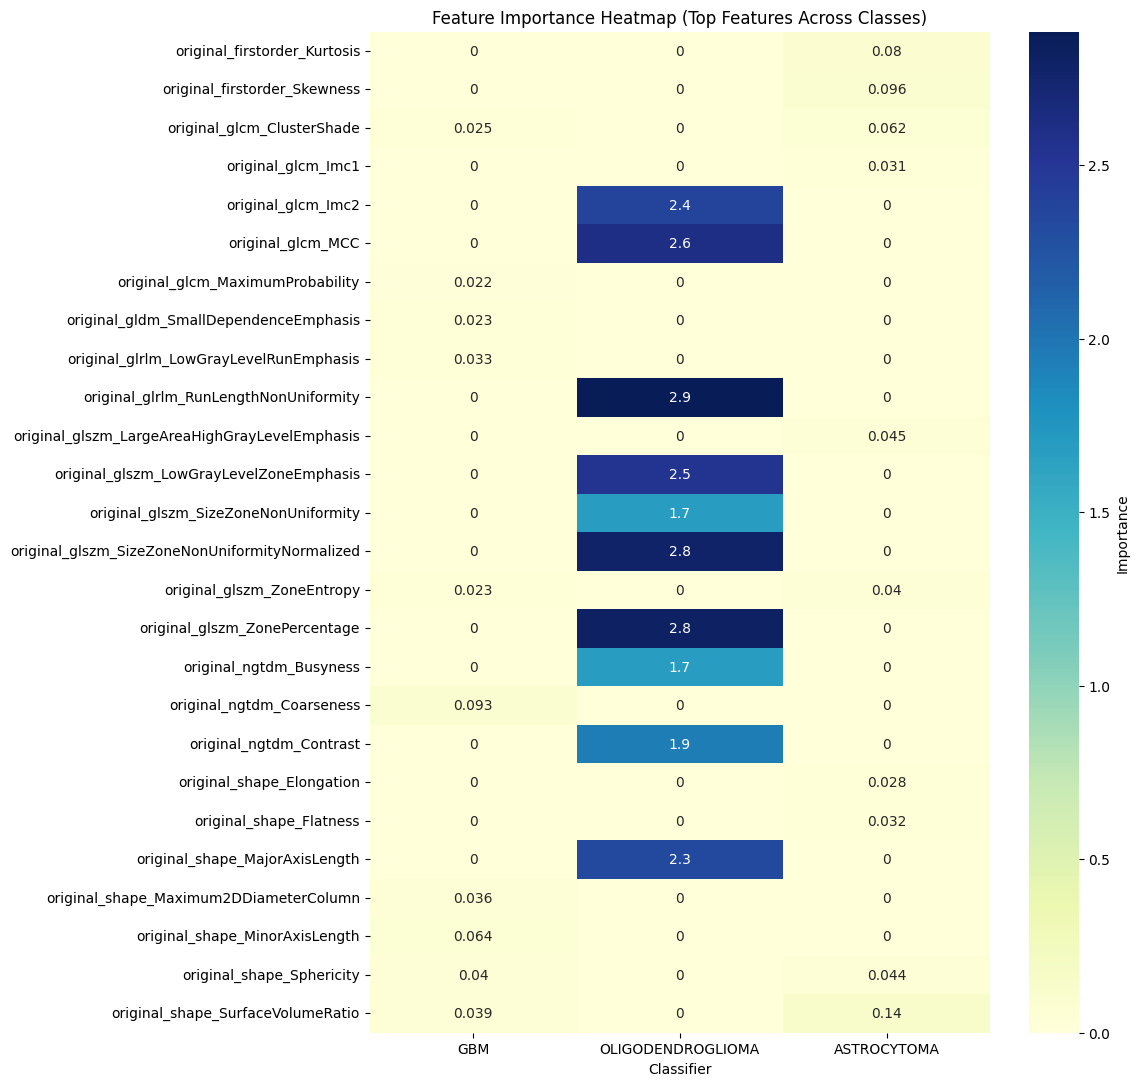

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Combine all top features into a set
top_features_all = set()
for df in feature_importances.values():
    top_features_all.update(df["Feature"].tolist())

top_features_all = sorted(top_features_all)

# 🔁 Build a matrix: rows = features, cols = classes
importance_matrix = pd.DataFrame(index=top_features_all)

for class_name, df in feature_importances.items():
    importance_matrix[class_name] = importance_matrix.index.map(
        dict(zip(df["Feature"], df["Importance"]))
    )

importance_matrix = importance_matrix.fillna(0)

# 📊 Plot heatmap
plt.figure(figsize=(10, len(top_features_all) * 0.5))
sns.heatmap(importance_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Importance'})
plt.title("Feature Importance Heatmap (Top Features Across Classes)")
plt.xlabel("Classifier")
plt.ylabel


### 2. Side-by-Side Bar Chart: Feature vs Class Importance

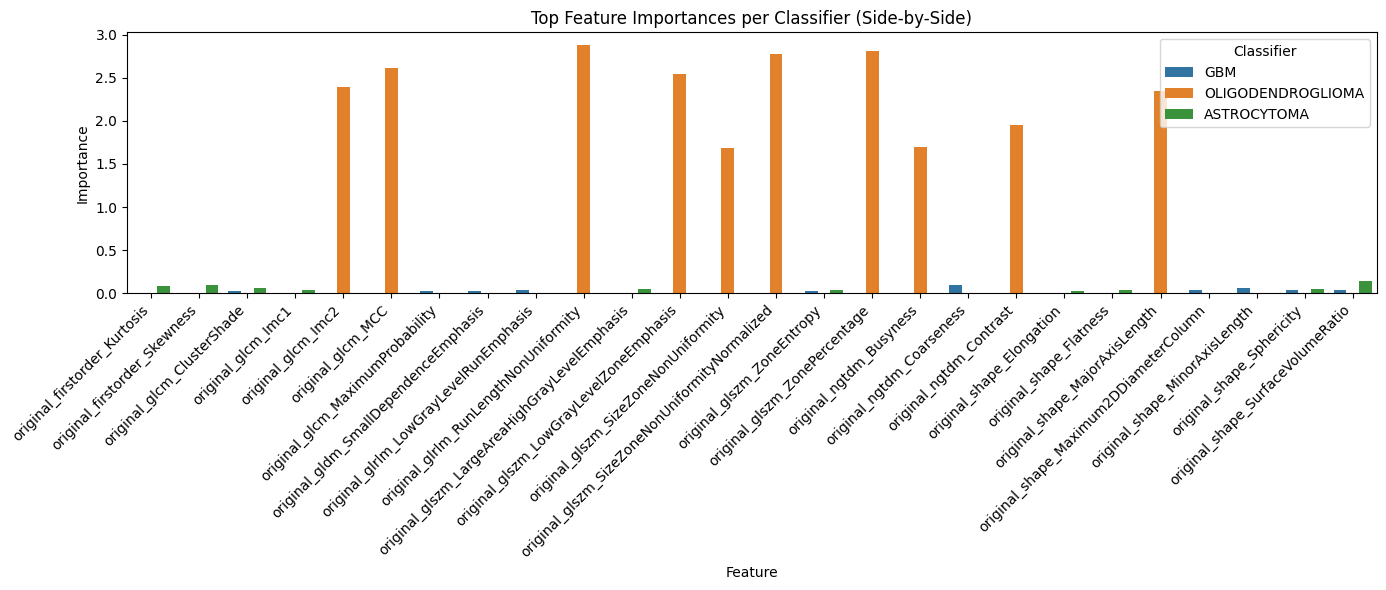

In [ ]:
# 🔁 Melt DataFrame for seaborn barplot
importance_melted = importance_matrix.reset_index().melt(id_vars="index",
                                                         var_name="Classifier",
                                                         value_name="Importance")
importance_melted = importance_melted.rename(columns={"index": "Feature"})

# 📈 Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=importance_melted, x="Feature", y="Importance", hue="Classifier")
plt.title("Top Feature Importances per Classifier (Side-by-Side)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 9. One Vs Rest Model Performance Visualizations

## Confusion Matrix Heatmap

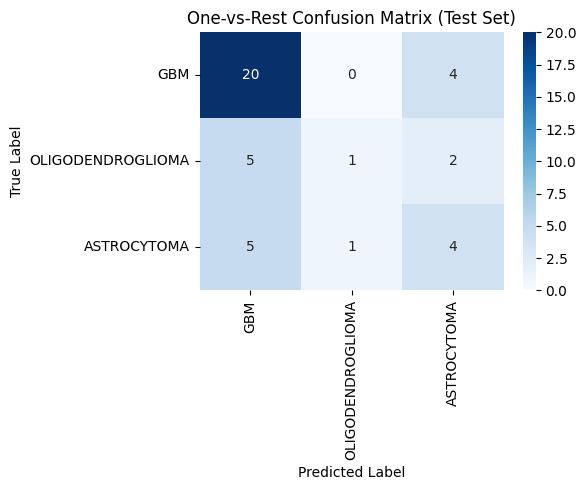

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=list(classifiers.keys()))

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(classifiers.keys()),
            yticklabels=list(classifiers.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("One-vs-Rest Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


## Multiclass ROC Curve (One-vs-Rest)

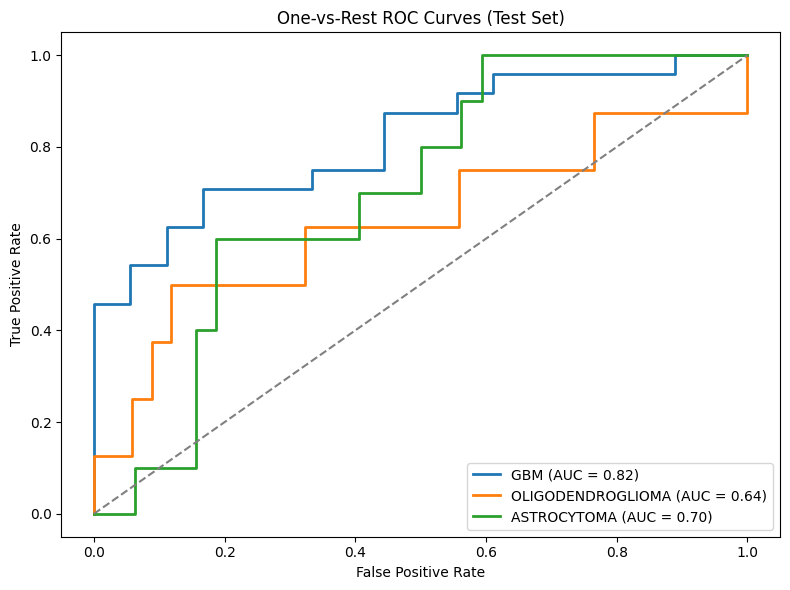

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=list(classifiers.keys()))  # shape = (n_samples, n_classes)

# ROC for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(classifiers.keys()):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
